# Data access and discovery

## Authors & Contributors

### Authors

- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)
- Alejandro Coca-Castro, The Alan Turing Institute (United Kingdom), [@acocac](https://github.com/acocac)
- Anne Fouilloux, Simula Research Laboratory (Norway), [@annefou](https://github.com/annefou)

### Contributors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)

<div class="alert alert-info">
    <i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> <b>Overview</b>
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>How to access online (remote) datasets?</li>
        <li>How to prepare and discover online geoscience datasets?</li>
        <li>What is Analysis Ready, Cloud Optimized data (ARCO)?</li>
        <li>What is stac?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn to access datasets from online object storage</li>
        <li>Learn about preparing and discovery online datasets</li>
        <li>Learn about Analysis Cloud Optimized (ARCO) data</li>
        <li>Learn about stac</li>
    </ul>
</div>

## Context

We will be using Long Term Statistics (1999-2019) product provided by the [Copernicus Global Land Service](https://land.copernicus.eu/global/index.html) over Lombardia and access them through [S3-compatible storage](https://en.wikipedia.org/wiki/Amazon_S3). We will also explore [Sentinel-2 Cloud-Optimised Dataset](https://registry.opendata.aws/sentinel-2-l2a-cogs/) online through SpatioTemporal Asset Catalogs ([STAC](https://stacspec.org/en)).

## Setup

This episode uses the following main Python packages:

- xarray {cite:ps}`c-xarray-hoyer2017` with [`netCDF4`](https://pypi.org/project/h5netcdf/) and [`h5netcdf`](https://pypi.org/project/h5netcdf/) engines
- s3fs {cite:ps}`c-s3fs-2016`
- pystac-client {cite:ps}`c-pystac-2024`
- odc-stac  {cite:ps}`c-odc-2024`
- rioxarray {cite:ps}`b-rioxarray-snow2022`
- matplotlib {cite:ps}`b-matplotlib-Hunter2007`
- cartopy {cite:ps}`b-cartopy-mo2010`

Please install these packages if not already available in your Python environment.

### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Introduction to the Long Term statistics
CGLS LTS are computed over a time span of 20 years aggregated over separate 10-day periods (month/01,month/11, month/21). For each date the long term minimum, maximum, mean, median and standard deviation are computed.

### S3-compatible Object Storage to access online data

Up to now we have downloaded data locally and then opened with Xarray `open_dataset`. When willing to manipulate large amount of data, this approach is not optimal (since it requires a lot of unnecessary local downloads). Sharing data online as Object Storage allows for data sharing and access to much larger amounts of data.

One of the most popular methods to access online remote data is through Amazon Simple Storage Service (S3) and you don't necessarily need to use Amazon services to benefit from S3 object storage. Many other providers offer S3-compatible object storage that can be accessed in a very similar way.

Below we will be accessing online the NDVI Long Term Statistics from Copernicus Land Service that we have publicly stored in OpenStack Object storage (Swift).

In [1]:
import s3fs
import xarray as xr

In [2]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })

:::{tip}
The parameter `anon` is for `anonymous` and is set to `True` because the data we have stored at `https://object-store.cloud.muni.cz` is public
:::

#### List files and folders in existing buckets

Instead of organizing files in various folders, object storage systems store files in a flat organization of containers (called "buckets"). 

In [3]:
fs.ls('foss4g-data')

['foss4g-data/CGLS_LTS_1999_2019',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia',
 'foss4g-data/test']

In [4]:
fs.ls('foss4g-data/CGLS_LTS_1999_2019_Lombardia')

['foss4g-data/CGLS_LTS_1999_2019_Lombardia/',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0111_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0121_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0201_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0211_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0221_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0301_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0311_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0321_GLOBE_VGT-PROBAV_V3.0.1.nc',


#### Access remote files from S3-compatible Object Storage

In [5]:
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc'

In [6]:
LTS = xr.open_dataset(fs.open(s3path))

In [7]:
LTS

<xarray.Dataset>
Dimensions:  (lon: 331, lat: 235)
Coordinates:
  * lon      (lon) float64 8.5 8.509 8.518 8.527 ... 11.42 11.43 11.44 11.45
  * lat      (lat) float64 46.7 46.69 46.68 46.67 ... 44.63 44.63 44.62 44.61
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 ...
    median   (lat, lon) float32 ...
    max      (lat, lon) float32 ...
    mean     (lat, lon) float32 ...
    stdev    (lat, lon) float32 ...
    nobs     (lat, lon) float32 ...
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

In [8]:
LTS.sel(lat=45.88, lon=8.63, method='nearest')['min'].values

array(0.264, dtype=float32)

:::{warning}
The same dataset can be available from different locations e.g. [CGLS distributor VITO](https://vito.be/en), Zenodo, S3-compatible OpenStack Object storage (Swift), etc.
How do you know if it corresponds to the very same dataset? You cannot know except if the datasets have a persistent identifier such as a Digital Object Identifier.
It is therefore recommended *1)* to be extra careful about where you get your datasets, and *2)* to double check that the content is exactly what you expect (for instance, you can perform basic quality checks).                                                            
:::

#### Access multiple remote files 

In [9]:
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_*.nc'

In [10]:
remote_files = fs.glob(s3path)
remote_files

['foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0111_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0121_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0201_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0211_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0221_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0301_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0311_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI_c_gls_NDVI-LTS_1999-2019-0321_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019_Lombardia/AOI

We need to add a time dimension to concatenate data. For this, we define a function that will be called for each remote file (via the `preprocess` parameter of Xarray `open_mfdataset`.)

In [11]:
from datetime import datetime

In [12]:
def preprocess(ds):
    t = datetime.strptime(ds.attrs['identifier'].split(':')[-1].split('_')[1].replace('1999-', ''), "%Y-%m%d")
    return(ds.assign_coords(time=t).expand_dims('time'))   

Xarray `open_mfdataset` allows opening multiple files at the same time.

In [13]:
# Iterate through remote_files to create a fileset
fileset = [fs.open(file) for file in remote_files]

When opening remote files, you can also select the variables you wish to analyze.

In [14]:
LTS = xr.open_mfdataset(fileset, combine='nested', concat_dim=['time'],  preprocess=preprocess,
                        decode_coords="all")
LTS

<xarray.Dataset>
Dimensions:  (lon: 331, lat: 235, time: 36)
Coordinates:
  * lon      (lon) float64 8.5 8.509 8.518 8.527 ... 11.42 11.43 11.44 11.45
  * lat      (lat) float64 46.7 46.69 46.68 46.67 ... 44.63 44.63 44.62 44.61
    crs      |S1 b''
  * time     (time) datetime64[ns] 2019-01-01 2019-01-11 ... 2019-12-21
Data variables:
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 235, 331), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 235, 331), meta=np.ndarray>
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 235, 331), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 235, 331), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 235, 331), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 235, 331), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

#### Visualize maximum NDVI for January 2015

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Text(0.5, 1.0, 'Maximum NDVI over Lombardia')

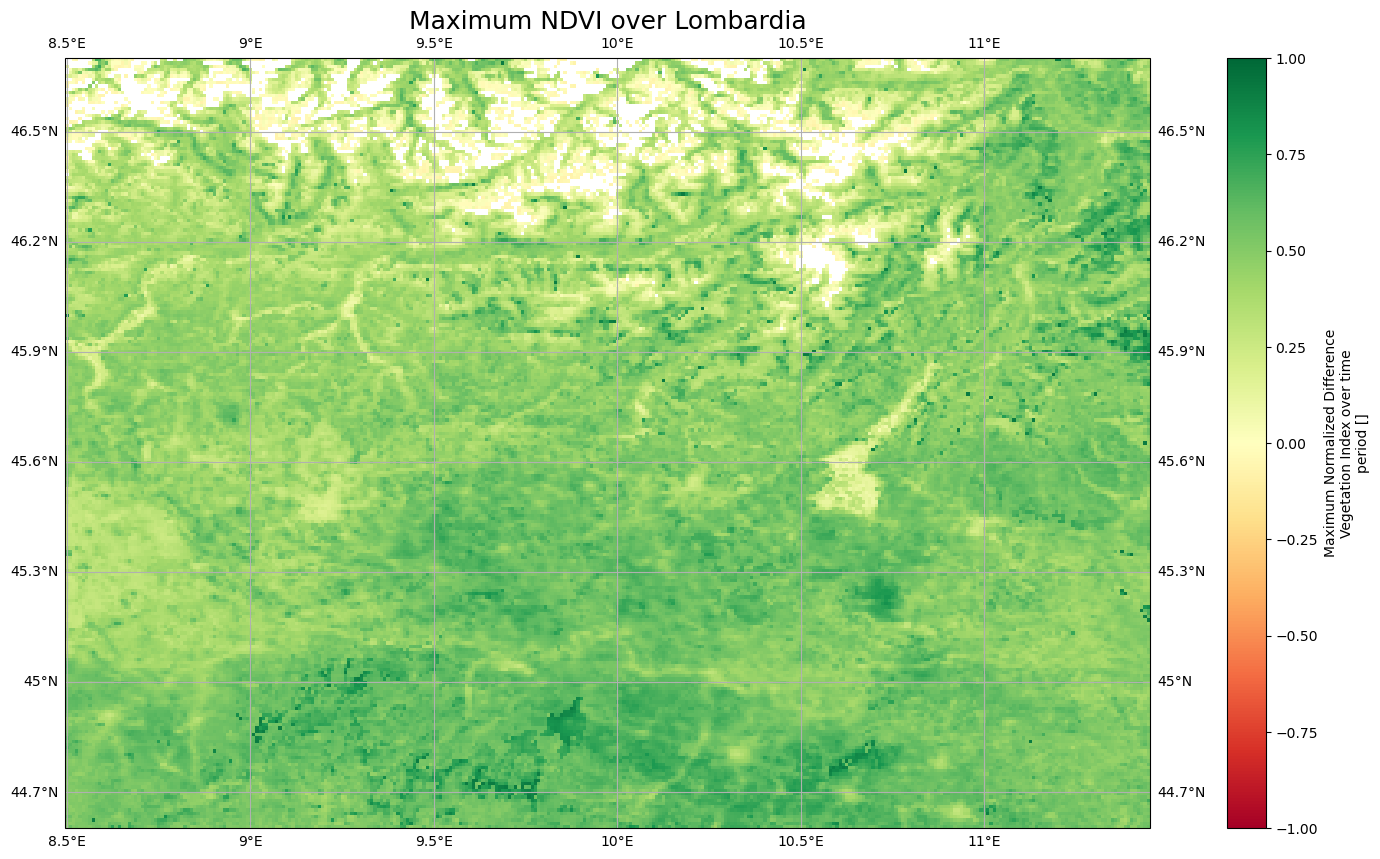

In [16]:
fig = plt.figure(1, figsize=[20, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.set_extent([5, 15, 40, 50], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

LTS.sel(time="2015-01-01", method="nearest")["max"].plot(ax=ax, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), cmap="RdYlGn")

# One way to customize your title
plt.title("Maximum NDVI over Lombardia", fontsize=18)

:::{tip}
If you use one of xarray’s open methods such as xarray.open_dataset to load netCDF files with the default engine, it is recommended to use decode_coords=”all”. This will load the grid mapping variable into coordinates for compatibility with rioxarray. See [rioxarray documentation](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html#xarray).
:::

## Preparing and discover online datasets

With the plethora of cloud storage, there are many available online datasets. To ease the preparation and discovery of such datasets, we describe emerging community-driven initiatives promoting standards suited to both geospatial and geoscience communities. Most of the material below is adapted from a previous Pangeo 101 training {cite:ps}`galaxy2022-pangeo`.

### Analysis Ready, cloud optimized data (ARCO)
When analyzing data at scale, the data format used is key. For years, the main data format was netCDF e.g. Network Common Data Form but with the use of cloud computing and interest in Open Science, different formats are often more suitable.

Formats for analyzing data from the cloud are refered to as "Analysis Ready, Cloud Optimized" data formats or in short ARCO. Find further info about ARCO datasets in {cite:ps}`Abernathey2022-arco`.

What is "Analysis Ready"?
* Think in terms of "Datasets" not "data files"
* No need for tedious homogenizing / cleaning setup guides
* Curated and cataloged

What is "Cloud Optimized"?
* Compatible with object storage e.g. access via HTTP
* Supports lazy access and intelligent subsetting
* Integrates with high-level analysis libraries and distributed frameworks

Instead of having a big dataset, ARCO datasets are chunked appropriately for analysis and have rich metadata (See Figure 1).

<img src="https://github.com/galaxyproject/training-material/blob/696dfecd4c88e59b487a7a3557cfedca6ec5754b/topics/climate/images/arco_data.png?raw=true" align="Left" /></a>

*Fig 1. Example of an ARCO dataset. Source: {cite:ps}`galaxy2022-pangeo`.*

### Spatio Temporal Asset Catalogs (STAC)

The [STAC](https://stacspec.org/en/) specification is a common language to describe geospatial information, so it can more easily be worked with, indexed, and discovered. The development of the STAC specification has simplified and standardized access to satellite datasets. This specification allows users to easily access metadata and raw data, and filter data based on attributes such as satellite type, cloud cover, area of interest, and dates.

#### Why STAC?
* Each provider has its own catalog and interface (APIs).
* Every time you want to access a new catalog, you need to change your program.
* We have lots of data providers and each with a bespoke interface.
* It is becoming quickly difficult for programmers who need to design a new data connector each time.

#### Features
- STAC catalogs are extremely simple.
- They are composed of three layers:
    - **Catalogs**
        - **Collections**
            - **Items**
- STAC is very popular for Earth Observation satellite imagery.
- For instance it can be used to access Sentinel-2 in AWS (see Figure 3).


<img src="https://github.com/galaxyproject/training-material/blob/696dfecd4c88e59b487a7a3557cfedca6ec5754b/topics/climate/images/sentinel2_AWS.png?raw=true" align="Left" /></img>

*Fig 3. Example of STAC collection of Sentinel-2 images hosted in AWS. Source: {cite:ps}`galaxy2022-pangeo`.*

#### Python packages to search items from STAC catalogs

- `pystac-client` interacts with SpatioTemporal Asset Catalogs (STAC) to discover and access geospatial data easily. 
- `odc-stac` is  based on [Open Data Cube (ODC)](https://www.opendatacube.org) and facilitates the management and analysis of large volumes of data accessible from STAC.

In [17]:
from pystac_client import Client
from odc.stac import load
import odc.geo

#### Search for Items

Let's check if items are available for given combination of collection, date, geometry, query, etc.

In [18]:
# use publically available stac link such as
client = Client.open("https://earth-search.aws.element84.com/v1") 

# ID of the collection
collection = "sentinel-2-l2a"

# Geometry of AOI e.g. small area over Lombardia (Italy)
geometry = {
   
        "coordinates": [
          [
            [
              9.621052726784058,
              45.863683047884365
            ],
            [
              9.621052726784058,
              45.72725813387305
            ],
            [
              9.874045082377933,
              45.72725813387305
            ],
            [
              9.874045082377933,
              45.863683047884365
            ],
            [
              9.621052726784058,
              45.863683047884365
            ]
          ]
        ],
    "type": "Polygon",
}

##### Search items for a specific date

In [19]:
# Specific Date
date_YYMMDD = "2023-01-01"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_YYMMDD
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2B_32TNR_20230101_0_L2A', 'properties': {'created': '2023-01-01T15:38:00.242Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 93.50211, 'proj:epsg': 32632, 'mgrs:utm_zone': 32, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'NR', 'grid:code': 'MGRS-32TNR', 'view:sun_azimuth': 166.183161249214, 'view:sun_elevation': 20.248337225593005, 's2:degraded_msi_data_percentage': 0.0022, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 2.043006, 's2:cloud_shadow_percentage': 4.12275, 's2:vegetation_percentage': 0.054559, 's2:not_vegetated_percentage': 0.154664, 's2:water_percentage': 0.038135, 's2:unclassified_percentage': 0.00642, 's2:medium_proba_clouds_percentage': 7.874592, 's2:high_proba_clouds_percentage': 84.83994, 's2:thin_cirrus_percentage': 0.787582, 's2:snow_ice_percentage': 0.0

##### Search items for a specific month

In [20]:
# Complete month
date_YYMM = "2023-01"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_YYMM
) 
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2B_32TNR_20230131_0_L2A', 'properties': {'created': '2023-01-31T19:20:02.816Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.112465, 'proj:epsg': 32632, 'mgrs:utm_zone': 32, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'NR', 'grid:code': 'MGRS-32TNR', 'view:sun_azimuth': 162.471016303525, 'view:sun_elevation': 25.273284914117596, 's2:degraded_msi_data_percentage': 0.0026, 's2:nodata_pixel_percentage': 3e-05, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 9.818108, 's2:cloud_shadow_percentage': 0.002522, 's2:vegetation_percentage': 31.585425, 's2:not_vegetated_percentage': 51.599735, 's2:water_percentage': 2.399037, 's2:unclassified_percentage': 0.003381, 's2:medium_proba_clouds_percentage': 0.00499, 's2:high_proba_clouds_percentage': 0.010272, 's2:thin_cirrus_percentage': 0.097203, 's2:snow_ice_percentag

##### Search items for a date range

In [21]:
# Date range
date_range = "2023-01-10/2023-01-20"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_range
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2A_32TNR_20230116_0_L2A', 'properties': {'created': '2023-01-16T16:58:50.344Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 95.510781, 'proj:epsg': 32632, 'mgrs:utm_zone': 32, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'NR', 'grid:code': 'MGRS-32TNR', 'view:sun_azimuth': 164.233149382057, 'view:sun_elevation': 21.990654775921797, 's2:degraded_msi_data_percentage': 0.0075, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 1.055385, 's2:cloud_shadow_percentage': 3.343091, 's2:vegetation_percentage': 0, 's2:not_vegetated_percentage': 0.000202, 's2:water_percentage': 0.007004, 's2:unclassified_percentage': 4e-05, 's2:medium_proba_clouds_percentage': 47.175184, 's2:high_proba_clouds_percentage': 46.2935, 's2:thin_cirrus_percentage': 2.042097, 's2:snow_ice_percentage': 0.083497, 

##### Search items for a specific date and cloud cover and vegetation conditions

In [22]:
# additional filters as per metadata 
date_YYMM = "2023-01"
filters = {
    "eo:cloud_cover":{"lt":0.2},
    "s2:vegetation_percentage": {"gt": 25}
}
# run pystac client search to see available dataset 
search = client.search(collections=[collection], intersects=geometry , query=filters ,datetime=date_YYMM) #bbox=tas_bbox
#spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2B_32TNR_20230131_0_L2A', 'properties': {'created': '2023-01-31T19:20:02.816Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.112465, 'proj:epsg': 32632, 'mgrs:utm_zone': 32, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'NR', 'grid:code': 'MGRS-32TNR', 'view:sun_azimuth': 162.471016303525, 'view:sun_elevation': 25.273284914117596, 's2:degraded_msi_data_percentage': 0.0026, 's2:nodata_pixel_percentage': 3e-05, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 9.818108, 's2:cloud_shadow_percentage': 0.002522, 's2:vegetation_percentage': 31.585425, 's2:not_vegetated_percentage': 51.599735, 's2:water_percentage': 2.399037, 's2:unclassified_percentage': 0.003381, 's2:medium_proba_clouds_percentage': 0.00499, 's2:high_proba_clouds_percentage': 0.010272, 's2:thin_cirrus_percentage': 0.097203, 's2:snow_ice_percentag

##### load the data in xarray format

In [23]:
data = load(search.items(), geopolygon=geometry, groupby="solar_day", chunks={})
data

<xarray.Dataset>
Dimensions:       (y: 1535, x: 1982, time: 1)
Coordinates:
  * y             (y) float64 5.079e+06 5.079e+06 ... 5.064e+06 5.064e+06
  * x             (x) float64 5.482e+05 5.482e+05 ... 5.68e+05 5.68e+05
    spatial_ref   int32 32632
  * time          (time) datetime64[ns] 2023-01-31T10:28:11.279000
Data variables: (12/32)
    aot           (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    blue          (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    coastal       (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    green         (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    nir           (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    nir08         (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    ...            ...
    rededge3-jp2  (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    scl-jp2       (time, y, x) uint8 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    swir16-jp2    (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    swir22-jp2    (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    visual-jp2    (time, y, x) float32 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>
    wvp-jp2       (time, y, x) uint16 dask.array<chunksize=(1, 1535, 1982), meta=np.ndarray>

##### create the index without considering scale or offset

In [24]:
ndvi = (data.nir - data.red) / (data.nir + data.red)

##### Quickly visualize the generated vegetation index

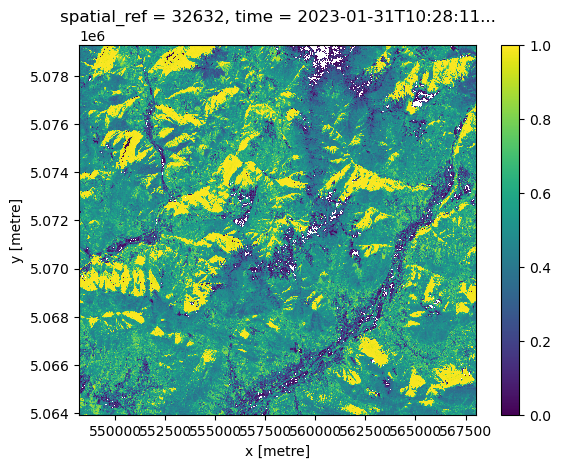

In [25]:
ndvi.where(ndvi <= 1.).plot()

##### Use native projection to plot on geographical map

Text(0.5, 1.0, 'NDVI')

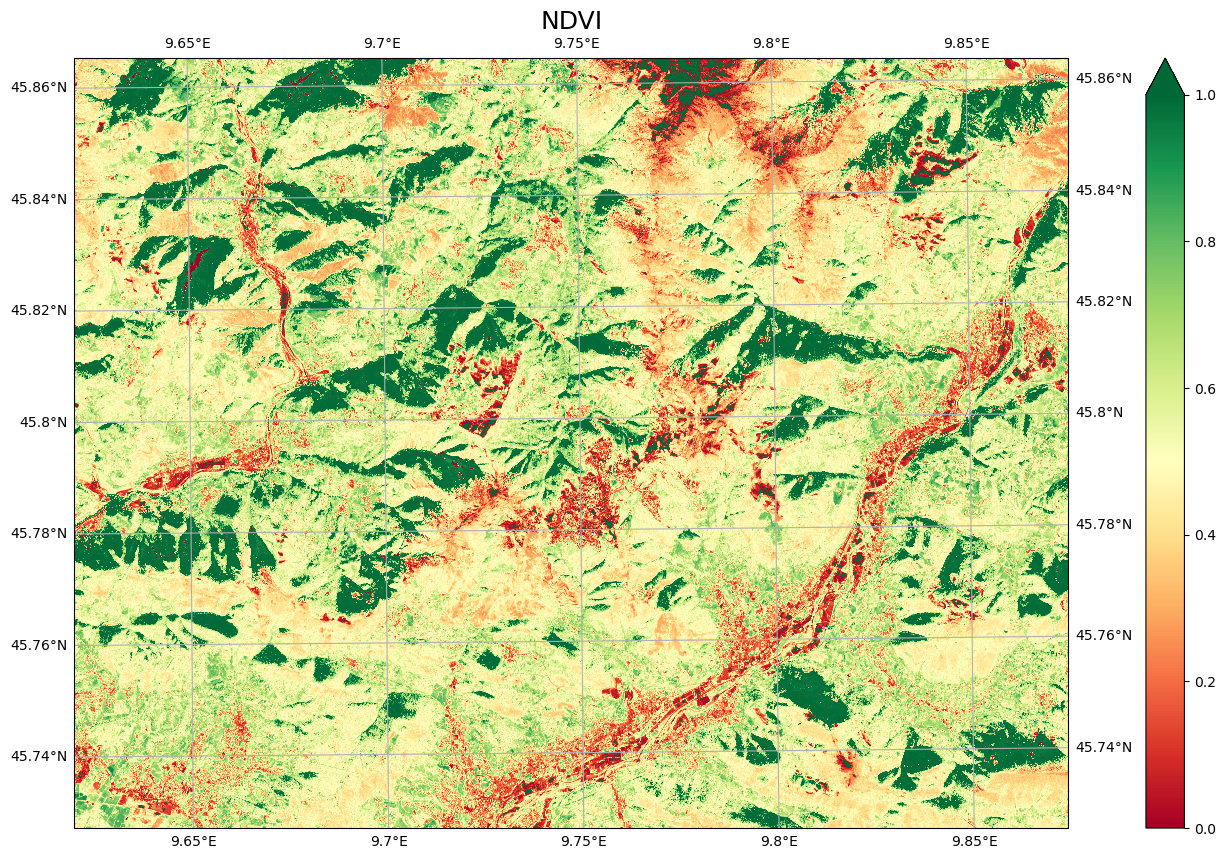

In [26]:
proj = ccrs.epsg(ndvi.spatial_ref.values)

fig = plt.figure(1, figsize=[20, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=proj)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

ndvi.plot(ax=ax, transform=proj, vmax=1, cmap="RdYlGn")

# One way to customize your title
plt.title("NDVI", fontsize=18)

#### Reproject to EPSG 4326

In [27]:
import rioxarray

In [28]:
ndvi.rio.write_crs(ndvi.spatial_ref.values, inplace=True)

<xarray.DataArray (time: 1, y: 1535, x: 1982)>
dask.array<truediv, shape=(1, 1535, 1982), dtype=float64, chunksize=(1, 1535, 1982), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.079e+06 5.079e+06 ... 5.064e+06 5.064e+06
  * x            (x) float64 5.482e+05 5.482e+05 5.482e+05 ... 5.68e+05 5.68e+05
  * time         (time) datetime64[ns] 2023-01-31T10:28:11.279000
    spatial_ref  int64 0

In [29]:
reprojected = ndvi.rio.reproject("EPSG:4326")
reprojected

<xarray.DataArray (time: 1, y: 1212, x: 2226)>
array([[[1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
         1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
        [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
         1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
        [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
         1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
        ...,
        [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
         1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
        [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
         1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
        [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
         1.79769313e+308, 1.79769313e+308, 1.79769313e+308]]])
Coordinates:
  * x            (x) float64 9.62 9.62 9.62 9.62 ... 9.876 9.876 9.876 9.876
  * y            (y) float64 45.87 45.87 45.87 45.86 ... 45.73 45.73 45.73 45.73
  * time         (time) datetime64[ns] 2023-01-31T10:28:11.279000
    spatial_ref  int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

In [30]:
reprojected = reprojected.rename(x='lon', y='lat')

##### Save into geotiff

In [32]:
reprojected.rio.to_raster("ndvi.tiff")

##### open geotiff with rioxarray

In [33]:
ndvi = xr.open_dataset("ndvi.tiff", engine="rasterio")
ndvi

<xarray.Dataset>
Dimensions:      (band: 1, x: 2226, y: 1212)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 9.62 9.62 9.62 9.62 ... 9.876 9.876 9.876 9.876
  * y            (y) float64 45.87 45.87 45.87 45.86 ... 45.73 45.73 45.73 45.73
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

##### Visualize on a map

Text(0.5, 1.0, 'NDVI')

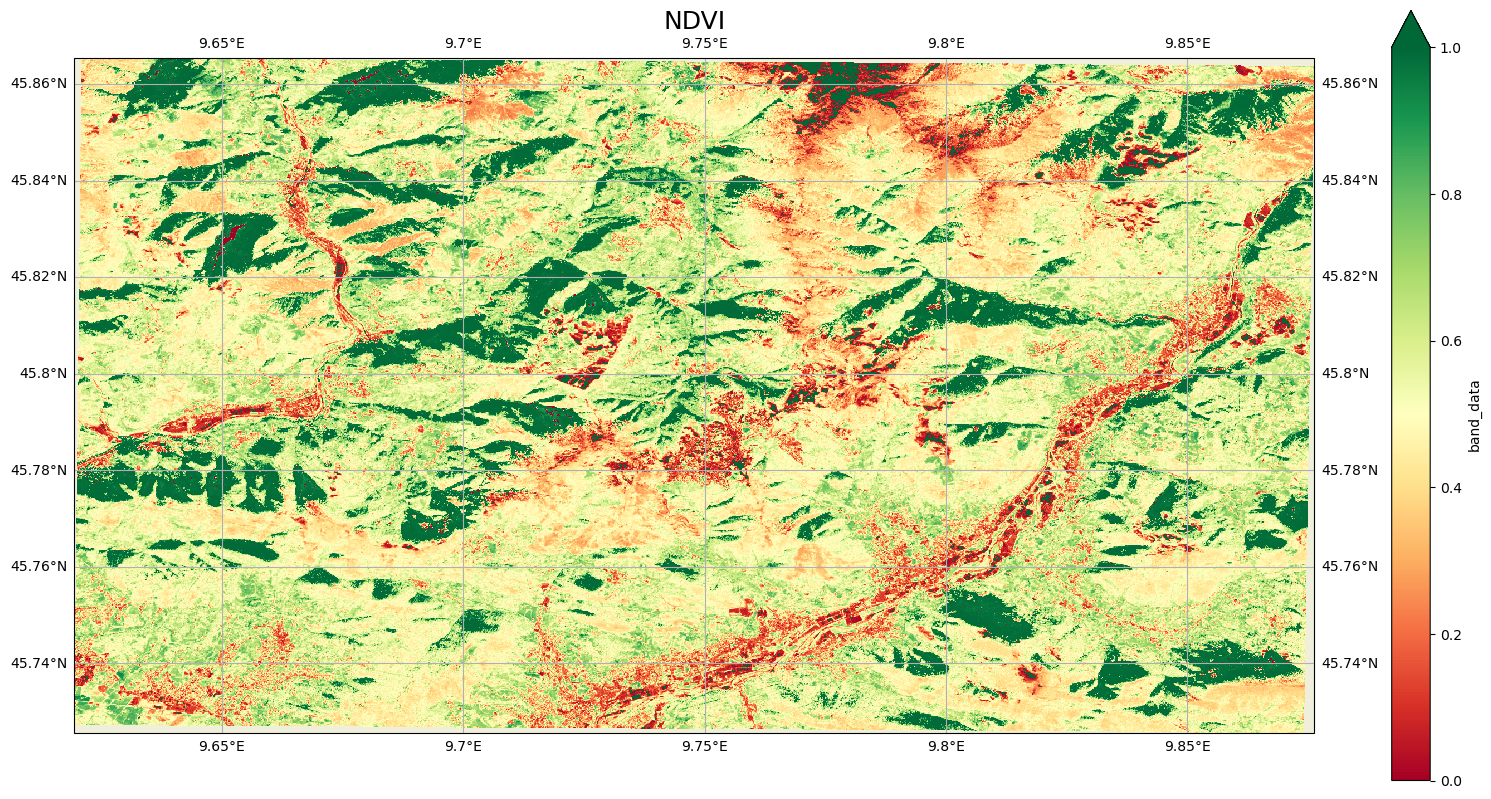

In [35]:
fig = plt.figure(1, figsize=[20, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ndvi.band_data.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=1, cmap="RdYlGn")
#ax.set_extent([5.0, 13.0, 44, 50], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
# One way to customize your title
plt.title("NDVI", fontsize=18)

<div class="alert alert-success">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Key Points</b>
    <br>
    <ul>
        <li>Access to remote dataset</li>
        <li>ARCO datasets</li>
        <li>STAC</li>
    </ul>
</div>

## References

```{bibliography}
:style: alpha
:filter: topic % "data-access"
```

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "access" and topic % "package"
:keyprefix: c-
```